In [1]:
import importlib
import lisa
lisa = importlib.reload(lisa)

from lisa.core.data_interface import DataInterface,PACKAGE_PATH
from lisa.core.genome_tools import Genome
from lisa.core.utils import indices_list_to_sparse_array
from lisa.core import data_interface
data_interface = importlib.reload(data_interface)

import configparser
import os
import pandas as pd
import numpy as np
import h5py as h5
import seaborn as sns

In [2]:
species = 'mm10'

In [3]:
old_data_path = os.path.join('data_conversion','old_data',species) 

v1_config = configparser.ConfigParser()
v1_config.read(os.path.join('data_conversion', 'lisa1_data.ini'))

['data_conversion/lisa1_data.ini']

# Step 1:

Go to NCBI Table browser and select the UCSC refGene table for mm10, output all fields. Download this table as "mm10.refseq"

In [10]:
!ls data_conversion/old_data/

hg38                  lisa_v1.2_hg38.tar.gz mm10
hg38.refseq           lisa_v1.2_mm10.tar.gz mm10.refseq


In [5]:
tad_info = pd.read_csv(v1_config.get(species, 'tad_info').format(prefix = old_data_path),
                        sep = '\t')
tad_info['tad_group'] = tad_info.k4me3_order_cluster.astype(str) + '-' + tad_info.tad_order_cluster.astype(str)

In [6]:
genome = pd.read_csv(os.path.join(PACKAGE_PATH, 'genomes',species + '.genome'), sep = '\t', header = None)
genome.columns = ['chrom','length']

In [11]:
genes = pd.read_csv(os.path.join('data_conversion', 'old_data', species + '.refseq'), sep = '\t')

In [12]:
genes = genes.merge(tad_info[['geneName','tad_group']], left_on='name2',
            right_on='geneName', how = 'left').fillna('None')

In [13]:
genes.merge(genome['chrom'], on = 'chrom', how = 'right')\
    [['name','chrom','strand','txStart','txEnd','exonStarts','exonEnds','name2', 'tad_group']]\
    .to_csv(os.path.join(PACKAGE_PATH,'genomes',species + '.refseq'), header = None, index = None, sep = '\t')

In [14]:
refseq=os.path.join(PACKAGE_PATH,'genomes',species + '.refseq')

# Step 2:

Download old LISA data:

```
wget -c http://lisa.cistrome.org/cistromedb_data/lisa_v1.2_mm10.tar.gz
```
and unpack into ./old_data/

# Step 3:

Instantiate a data inferface using the new genome and genes, then use it to generate RP maps

In [16]:
data = data_interface.DataInterface('mm10', window_size=1000, make_new=True)

Loading gene info ...


In [21]:
basic_rp_map, enhanced_rp_map = data.build_binned_rp_map('basic',10000), data.build_binned_rp_map('enhanced', 10000)

In [22]:
data.add_rp_map('basic_10K', basic_rp_map)
data.add_rp_map('enhanced_10K', enhanced_rp_map)

# Step 4: 

Load the old genome format and map to the new bins

In [23]:
old_genome = Genome.from_file(v1_config.get(species,'chrom_len').format(prefix = old_data_path),
                             window_size=1000, _sort=False)

genome_map = old_genome.map_genomes(data.genome)
genome_map = np.array(genome_map)

Load in old metadata

In [48]:
metadata = pd.read_csv(v1_config.get('basics','meta').format(prefix = old_data_path), encoding='latin', sep = '\t')\
    .set_index('id')
metadata.index = metadata.index.astype(str)
motif_meta = pd.read_csv(v1_config.get('basics','motif').format(prefix = old_data_path), encoding='latin', sep = '\t')\
    .set_index('id')
motif_meta['factor'] = motif_meta.symbol

# Step 5:

Transfer accessibility arrays to new format

In [5]:
def load_accessibility_data(technology, old_data_path):
    
    with h5.File(v1_config.get(species, technology + '_count').format(prefix = old_data_path), 'r') as old_data:
        dataset_ids = np.array(old_data['IDs'][...]).astype(str)
        acc_matrix = np.array(old_data['OrderCount'][...])
        
    return acc_matrix, dataset_ids

def add_accessibility_matrix(data, technology, acc_matrix, dataset_ids,*, rp_maps, rp_map_styles, metadata,
                            reads_range):
    
    headers = data.get_metadata_headers(technology)
    
    for i, dataset_id in enumerate(dataset_ids):

        dataset_id = str(dataset_id).split('_')[0]
        sample_metadata = metadata.loc[dataset_id, headers + ['qc']].to_dict()

        sample_acc = np.array(acc_matrix[:, i]).reshape(-1)

        if int(sample_metadata['qc']) == 1 and (reads_range[0] <= sample_acc.sum() <= reads_range[1]):
            data.add_profile_data(technology, str(dataset_id), sample_acc, rp_maps, 
                                      rp_map_styles, **sample_metadata)
            
def convert_accessibility(*,data,technology, old_data_path, bin_map, 
                          rp_maps, rp_map_styles, metadata, reads_range):
    
    acc_matrix, dataset_ids = load_accessibility_data(technology, old_data_path)

    projected_acc_matrix = np.vstack([
        data.project_array(r, bin_map, len(data.genome))
        for r in acc_matrix.T
    ]).T
    
    
    add_accessibility_matrix(data, technology, projected_acc_matrix, dataset_ids, 
                         rp_maps=rp_maps, rp_map_styles=rp_map_styles,
                        metadata = metadata, reads_range = reads_range)

In [26]:
accessibility_kwargs = dict(
    data = data,
    old_data_path=old_data_path,
    bin_map=genome_map, rp_maps = [basic_rp_map, enhanced_rp_map], rp_map_styles = ['basic_10K','enhanced_10K'],
    metadata = metadata
)

convert_accessibility(technology='DNase', **accessibility_kwargs, reads_range = (75000, 160000))

convert_accessibility(technology='H3K27ac', **accessibility_kwargs, reads_range = (130000, 160000))

# Check for bad data

In [23]:
import importlib

In [24]:
importlib.reload(data_interface)

<module 'lisa.core.data_interface' from '/Users/alynch/projects/lisa_project/liulab-lisa/lisa2/lisa/core/data_interface.py'>

In [25]:
data = data_interface.DataInterface(species, window_size=1000)

Loading gene info ...


In [29]:
acc_matrix, dataset_ids = load_accessibility_data('H3K27ac', old_data_path)

In [30]:
acc_sums = acc_matrix.sum(axis = 0)

<AxesSubplot:ylabel='Count'>

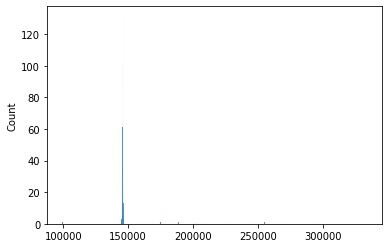

In [31]:
sns.histplot(acc_sums)

In [34]:
dataset_ids = np.array([x.split('_')[0] for x in dataset_ids])

In [35]:
bad_samples = dataset_ids[~np.logical_and(acc_sums >= 130000, acc_sums <= 160000, metadata.loc[dataset_ids].qc.values.astype(np.bool))]

In [36]:
profiles = data.list_profiles('H3K27ac')

In [39]:
for bad_samp in bad_samples:
    data.remove_profile('H3K27ac', bad_samp)

In [40]:
profiles = data.list_profiles('DNase')

# Step 6:

Transfer factor binding to new genome scale

In [27]:
old_genome_100bp = Genome.from_file(v1_config.get(species,'chrom_len').format(prefix = old_data_path),
                             window_size=100, _sort=False)

hits_binmap = np.array(old_genome_100bp.map_genomes(data.genome))

In [28]:
def load_tf_matrix(config_key, old_data_path, num_bins, metadata, offset = 0, skip_qc = False):

    with h5.File(v1_config.get(species, config_key)\
                 .format(prefix = old_data_path), 'r') as tf_hits:

        num_samples = len(list(tf_hits.keys()))
        
        indices, dataset_ids = [],[]
        
        for sample in tf_hits.keys():
            
            if not sample == 'IDs' and not sample == 'TFs':
                
                try:
                    sample_metadata = metadata.loc[sample]
                
                    if skip_qc or sample_metadata.qc == 1:
                        
                        factor_name = sample_metadata.factor.replace('/', '-').replace('_','-')

                        peaks = tf_hits[sample][...]
                        peaks = peaks - offset
                        
                        indices.append(peaks)
                        dataset_ids.append(sample)
                        
                except OSError:
                    print('\n\tError saving data for sample {}, factor: {}'\
                          .format(str(sample), sample_metadata.factor))
                except KeyError:
                    print('\n\tError: No metadata for sample {}'.format(str(sample)))
                    
        tf_matrix = indices_list_to_sparse_array(indices, num_bins)
        
        return tf_matrix, dataset_ids

def write_tf_matrix(data, technology, dataset_ids, tf_matrix, metadata):
    
    tf_matrix = tf_matrix.T.tocsr()
    
    for i, dataset_id in enumerate(dataset_ids):
        dataset_id = str(dataset_id)
        save_indices = tf_matrix[i, :].indices
        sample_metadata = metadata.loc[dataset_id, data.get_metadata_headers(technology)].to_dict()
        data.add_binding_data(technology, dataset_id, save_indices, **sample_metadata)
        
def convert_tf_binding(*, data, technology, config_key, old_data_path, original_num_bins, hits_binmap,
                metadata, offset = 0, skip_qc = False):
    
    tf_matrix, dataset_ids = load_tf_matrix(config_key, old_data_path, original_num_bins, 
                                        metadata, offset = offset, skip_qc = skip_qc)
    
    projected_tf_matrix = data.project_sparse_matrix(tf_matrix.T, hits_binmap, len(data.genome))
    
    write_tf_matrix(data, technology, dataset_ids, projected_tf_matrix, metadata)

### ChIP-seq data

In [29]:
convert_tf_binding(data = data, technology = 'ChIP-seq', config_key = 'tf_chipseq', old_data_path = old_data_path, 
                  original_num_bins = len(old_genome_100bp), metadata = metadata, offset = 1, skip_qc = False,
                  hits_binmap = hits_binmap)

### Motif data

In [30]:
convert_tf_binding(data = data, technology = 'Motifs', config_key = 'genome_100bp_motif_index99', old_data_path = old_data_path,
                original_num_bins = len(old_genome_100bp), metadata = motif_meta, offset = 0, skip_qc = True,
                hits_binmap = hits_binmap)

# 100bp hits data

In [31]:
fine_hitbin_data = data_interface.DataInterface(species, window_size=100, make_new=True)

Loading gene info ...


In [32]:
hits_fine_binmap = np.array(old_genome_100bp.map_genomes(fine_hitbin_data.genome))

In [33]:
convert_tf_binding(data = fine_hitbin_data, technology = 'ChIP-seq', config_key = 'tf_chipseq', old_data_path = old_data_path, 
                  original_num_bins = len(old_genome_100bp), metadata = metadata, offset = 1, skip_qc = False,
                  hits_binmap = hits_fine_binmap)

In [34]:
convert_tf_binding(data = fine_hitbin_data, technology = 'Motifs', config_key = 'genome_100bp_motif_index99', old_data_path = old_data_path,
                original_num_bins = len(old_genome_100bp), metadata = motif_meta, offset = 0, skip_qc = True,
                hits_binmap = hits_fine_binmap)

# Motifs mapping correctly?

In [42]:
matrix, dataset_ids, metadata = fine_hitbin_data.get_binding_data('Motifs')

In [46]:
factor_metadata = pd.DataFrame(metadata)

In [47]:
factor_metadata[factor_metadata.factor == 'RUNX1']

,sample_id,factor,source
3,M00082,RUNX1,Transfac
283,MC00312,RUNX1,Cistrome


In [49]:
np.where(dataset_ids == 'M00082')

(array([3]),)

In [51]:
dataset_ids[:5]

array(['M00041', 'M00062', 'M00072', 'M00082', 'M00085'], dtype='<U7')

In [60]:
with open('data_conversion/runx1_motif_windows.bed', 'w') as f:
    for ind in matrix[:, 3].tocoo().row[:1000]:
        ind = int(ind)
        print(fine_hitbin_data.genome.get_region(ind)[0], file = f)    

In [61]:
!head data_conversion/runx1_motif_windows.bed

chr1	3007900	3008000
chr1	3047900	3048000
chr1	3095500	3095600
chr1	3120400	3120500
chr1	3130600	3130700
chr1	3134200	3134300
chr1	3195700	3195800
chr1	3212300	3212400
chr1	3217000	3217100
chr1	3219800	3219900
